# Hybrid Pit Stop Strategy Advisor
## Modul 1: Fuzzy Logic (Penganalisis Kondisi)

Modul ini menggunakan logic fuzzy untuk menentukan urgensi pit stop berdasarkan:
1. **Umur Ban**: Persentase keausan ban.
2. **Compound Ban**: Tipe ban yang digunakan (Hard, Medium, Soft, Wet).
3. **Prediksi Cuaca**: Probabilitas hujan.

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

### DEFINISI VARIABEL (ANTECEDENTS & CONSEQUENT)

In [2]:
# Input: Umur Ban (0-60 Laps)
umur_ban = ctrl.Antecedent(np.arange(0, 61, 1), 'umur_ban')

# Input: Compound Ban (0-10 Scale)
compound = ctrl.Antecedent(np.arange(0, 11, 1), 'compound')

# Input: Prediksi Cuaca (0-100%)
cuaca = ctrl.Antecedent(np.arange(0, 101, 1), 'cuaca')

# Output: Urgensi Pit Stop (0-10)
urgensi = ctrl.Consequent(np.arange(0, 11, 1), 'urgensi')

### FUNGSI KEANGGOTAAN (MEMBERSHIP FUNCTIONS)

In [3]:
# menggunakan Triangular yang saling overlap agar output linear naik, bukan flat step

# Umur Ban: Baru, Awal, Tengah, Akhir, Kritis
umur_ban['baru'] = fuzz.trimf(umur_ban.universe, [0, 0, 10])
umur_ban['awal'] = fuzz.trimf(umur_ban.universe, [5, 15, 25])
umur_ban['tengah'] = fuzz.trimf(umur_ban.universe, [20, 30, 40])
umur_ban['akhir'] = fuzz.trimf(umur_ban.universe, [35, 45, 55])
umur_ban['kritis'] = fuzz.trapmf(umur_ban.universe, [50, 55, 60, 60])

# Compound: Hard, Medium, Soft, Wet
compound['hard'] = fuzz.trapmf(compound.universe, [0, 0, 2, 4])
compound['medium'] = fuzz.trimf(compound.universe, [2, 5, 8])
compound['soft'] = fuzz.trimf(compound.universe, [6, 8, 9])
compound['wet'] = fuzz.trapmf(compound.universe, [8, 9, 10, 10])

# Cuaca: Cerah, Mendung, Hujan
cuaca['cerah'] = fuzz.trapmf(cuaca.universe, [0, 0, 20, 40])
cuaca['mendung'] = fuzz.trimf(cuaca.universe, [30, 50, 70])
cuaca['hujan'] = fuzz.trapmf(cuaca.universe, [60, 80, 100, 100])

# Urgensi: Sangat Rendah, Rendah, Sedang, Tinggi, Sangat Tinggi
urgensi['sangat_rendah'] = fuzz.trimf(urgensi.universe, [0, 0, 3])
urgensi['rendah'] = fuzz.trimf(urgensi.universe, [2, 4, 6])
urgensi['sedang'] = fuzz.trimf(urgensi.universe, [5, 7, 9])
urgensi['tinggi'] = fuzz.trimf(urgensi.universe, [8, 9, 10])
urgensi['sangat_tinggi'] = fuzz.trimf(urgensi.universe, [9, 10, 10])

### ATURAN FUZZY (RULES)

In [4]:
# Rule 1: Kritis -> Sangat Tinggi
rule1 = ctrl.Rule(umur_ban['kritis'], urgensi['sangat_tinggi'])

# Rule 2: Akhir (Worn) -> Tinggi
rule2 = ctrl.Rule(umur_ban['akhir'], urgensi['tinggi'])

# Rule 3: Tengah (Mid-life) -> Sedang
rule3 = ctrl.Rule(umur_ban['tengah'], urgensi['sedang'])

# Rule 4: Awal (Fresh) -> Rendah
rule4 = ctrl.Rule(umur_ban['awal'], urgensi['rendah'])

# Rule 5: Baru -> Sangat Rendah
rule5 = ctrl.Rule(umur_ban['baru'], urgensi['sangat_rendah'])

# Rule 6: Wrong Tire (Hujan & Slick) -> Sangat Tinggi
rule6 = ctrl.Rule(cuaca['hujan'] & (compound['hard'] | compound['medium'] | compound['soft']), urgensi['sangat_tinggi'])

# Rule 7: Wrong Tire (Cerah & Wet) -> Sangat Tinggi
rule7 = ctrl.Rule(cuaca['cerah'] & compound['wet'], urgensi['sangat_tinggi'])

# Kumpulkan semua rule
pit_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
pit_advisor = ctrl.ControlSystemSimulation(pit_ctrl)

print("Sistem Fuzzy Logic Berhasil Diinisialisasi dengan Rule Gradient!")

Sistem Fuzzy Logic Berhasil Diinisialisasi dengan Rule Gradient!


### VISUALISASI

Visualisasi Fungsi Keanggotaan:


c:\Users\WINDOWS\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


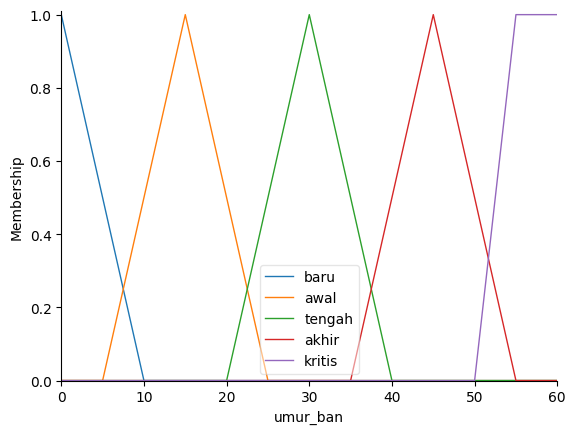

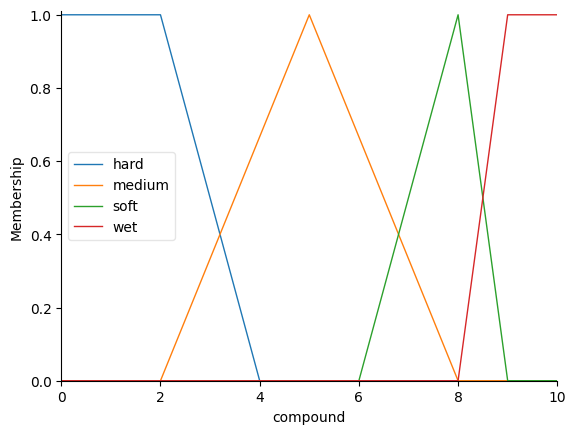

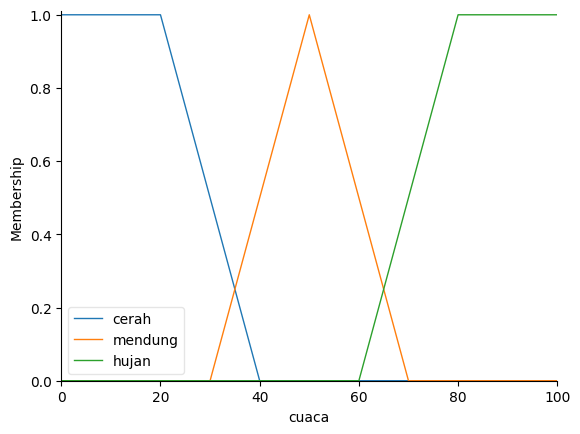

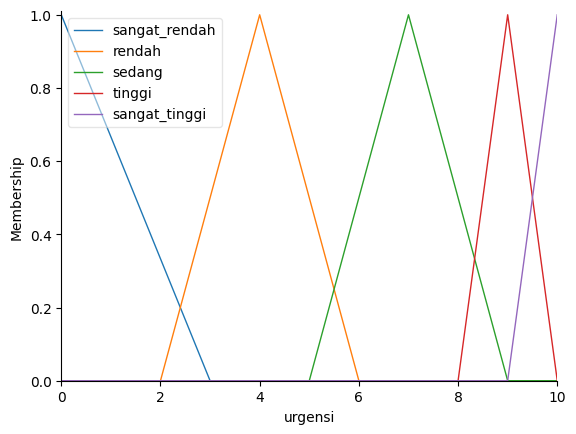

In [5]:
print("Visualisasi Fungsi Keanggotaan:")
umur_ban.view()
compound.view()
cuaca.view()
urgensi.view()

### SIMULASI / TESTING

Test Case 1 (Aus/Soft/Cerah) -> Urgensi: 9.67 / 10
Test Case 2 (Baru/Hard/Hujan) -> Urgensi: 5.42 / 10


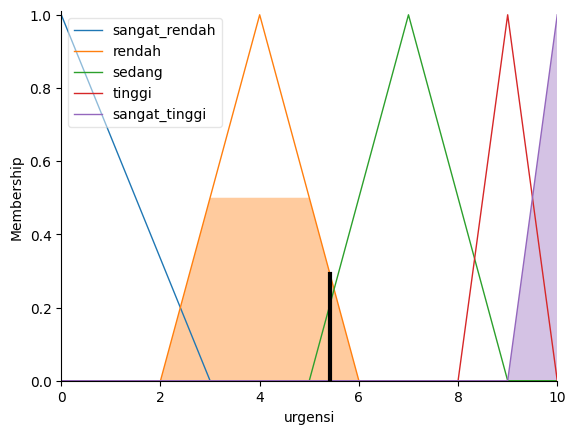

In [6]:
def hitung_urgensi(umur_val, compound_val, cuaca_val):
    pit_advisor.input['umur_ban'] = umur_val
    pit_advisor.input['compound'] = compound_val
    pit_advisor.input['cuaca'] = cuaca_val
    
    pit_advisor.compute()
    return pit_advisor.output['urgensi']

# Test Case 1: Ban Aus (75%), Pakai Soft (7), Cuaca Cerah (10%)
u1 = hitung_urgensi(75, 7, 10)
print(f"Test Case 1 (Aus/Soft/Cerah) -> Urgensi: {u1:.2f} / 10")

# Test Case 2: Hujan Deras (90%), Masih Pakai Hard (1)
u2 = hitung_urgensi(20, 1, 90)
print(f"Test Case 2 (Baru/Hard/Hujan) -> Urgensi: {u2:.2f} / 10")

# Visualisasi Output untuk Test Case 1
urgensi.view(sim=pit_advisor)

## Modul 2: Probabilistik (Risk Analyzer)

Modul ini menggunakan Bayesian Network untuk menghitung probabilitas Safety Car (SC) berdasarkan:
1. **Tipe Trek**: Street vs Permanent.
2. **Kondisi Cuaca**: Dry vs Wet.
3. **Histori SC**: Frekuensi SC di sirkuit tersebut (Low, Medium, High).

In [7]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx

### DEFINISI STRUKTUR NETWORK (DAG)

In [8]:
# Node: Trek, Cuaca, Histori_SC -> Probabilitas_SC
model = DiscreteBayesianNetwork([
    ('Trek', 'Probabilitas_SC'),
    ('Cuaca', 'Probabilitas_SC'),
    ('Histori_SC', 'Probabilitas_SC')
])


### DEFINISI CPT (CONDITIONAL PROBABILITY TABLES)

In [9]:
# Trek: 0=Permanent, 1=Street
cpd_trek = TabularCPD(variable='Trek', variable_card=2, values=[[0.7], [0.3]])

# Cuaca: 0=Dry, 1=Wet
cpd_cuaca = TabularCPD(variable='Cuaca', variable_card=2, values=[[0.8], [0.2]])

# Histori_SC: 0=Low, 1=Medium, 2=High
cpd_histori = TabularCPD(variable='Histori_SC', variable_card=3, values=[[0.3], [0.5], [0.2]])

# Probabilitas_SC (Target)
# Parents: Trek(2), Cuaca(2), Histori(3) -> Total kombinasi = 2*2*3 = 12 kolom
# Output: 0=No SC, 1=SC

# Urutan values harus sesuai dengan urutan evidence: Trek, Cuaca, Histori
# Kombinasi (Trek, Cuaca, Histori):
# (P,D,L), (P,D,M), (P,D,H), (P,W,L), (P,W,M), (P,W,H)
# (S,D,L), (S,D,M), (S,D,H), (S,W,L), (S,W,M), (S,W,H)

cpd_sc = TabularCPD(
    variable='Probabilitas_SC', variable_card=2,
    values=[
        # No SC (Probabilitas tidak terjadi SC)
        [0.9, 0.7, 0.5,  0.6, 0.4, 0.2,   0.7, 0.5, 0.3,  0.3, 0.2, 0.1],
        # Yes SC (Probabilitas terjadi SC)
        [0.1, 0.3, 0.5,  0.4, 0.6, 0.8,   0.3, 0.5, 0.7,  0.7, 0.8, 0.9]
    ],
    evidence=['Trek', 'Cuaca', 'Histori_SC'],
    evidence_card=[2, 2, 3]
)


In [10]:
# Tambahkan CPT ke model
model.add_cpds(cpd_trek, cpd_cuaca, cpd_histori, cpd_sc)

# Cek validitas model
assert model.check_model()
print("Model Bayesian Network Valid!")


Model Bayesian Network Valid!


### Visualisasi DAG

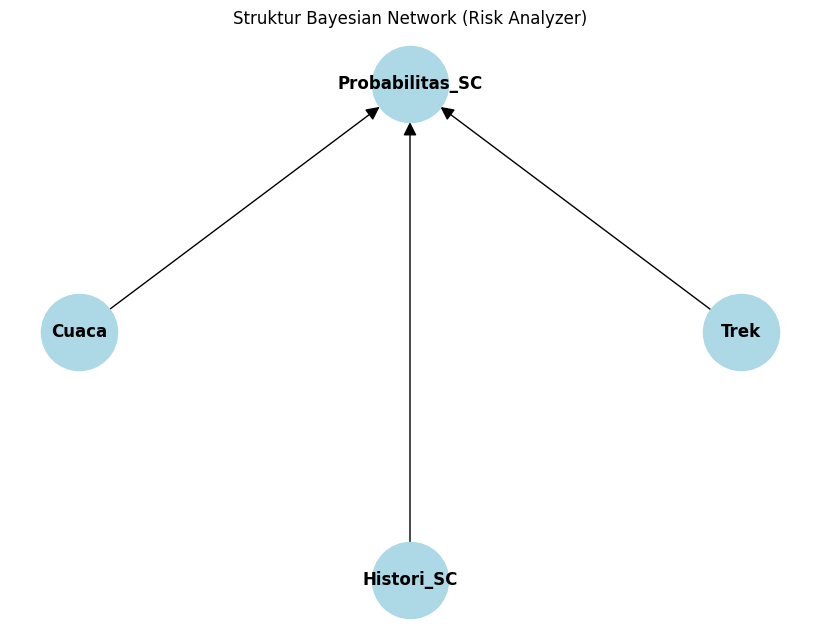

In [11]:
# Visualisasi DAG
plt.figure(figsize=(8, 6))
pos = nx.circular_layout(model)
nx.draw(nx.DiGraph(model), pos=pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, font_weight='bold', arrowsize=20)
plt.title("Struktur Bayesian Network (Risk Analyzer)")
plt.show()

### INFERENCE & VISUALISASI

Skenario: Street Track, Wet, High History
+--------------------+------------------------+
| Probabilitas_SC    |   phi(Probabilitas_SC) |
+====================+========================+
| Probabilitas_SC(0) |                 0.1000 |
+--------------------+------------------------+
| Probabilitas_SC(1) |                 0.9000 |
+--------------------+------------------------+


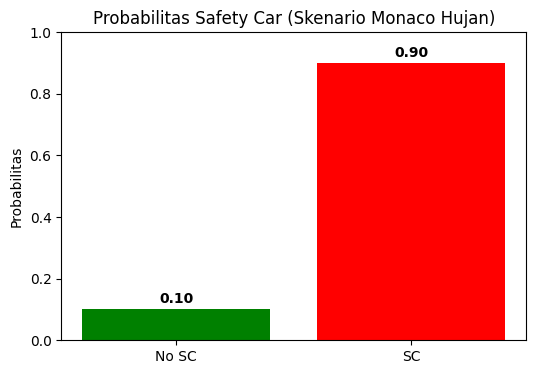

In [12]:
infer = VariableElimination(model)

# Kasus: Street Track (1), Wet (1), High History (2) -> Skenario Monaco Hujan
print("Skenario: Street Track, Wet, High History")
result = infer.query(variables=['Probabilitas_SC'], evidence={'Trek': 1, 'Cuaca': 1, 'Histori_SC': 2})
print(result)

# Visualisasi Distribusi Probabilitas
probs = result.values
labels = ['No SC', 'SC']

plt.figure(figsize=(6, 4))
plt.bar(labels, probs, color=['green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Probabilitas')
plt.title('Probabilitas Safety Car (Skenario Monaco Hujan)')
for i, v in enumerate(probs):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# --- MODUL 3: FIRST-ORDER LOGIC (VALIDATOR REGULASI) ---

"""
Modul ini bertugas memvalidasi strategi pit stop berdasarkan regulasi FIA Formula 1.
**Upgrade:** Menggunakan **Knowledge-Based Agent** (AIMA Logic) untuk inferensi aturan.
Referensi: FIA Formula 1 Sporting Regulations, Article 30.
"""

### SETUP & IMPORT AIMA LOGIC

In [13]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Menambahkan path ke library AIMA (Logical Agents)
aima_path = os.path.abspath('Logical Agents')
if aima_path not in sys.path:
    sys.path.append(aima_path)

try:
    from logic import FolKB, expr
    print("AIMA Logic library imported successfully.")
except ImportError:
    print("Error: Could not import logic.py. Make sure the path is correct.")

AIMA Logic library imported successfully.


### KNOWLEDGE BASE DEFINITION

In [14]:
def create_f1_kb():
    kb = FolKB()
    
    # Fakta Dasar: Klasifikasi Ban
    # Predikat: IsDry(x), IsWet(x)
    kb.tell(expr('IsDry(Soft)'))
    kb.tell(expr('IsDry(Medium)'))
    kb.tell(expr('IsDry(Hard)'))
    kb.tell(expr('IsWet(Intermediate)'))
    kb.tell(expr('IsWet(Wet)'))
    
    # Aturan: Validasi Strategi
    # Rule 1: Jika menggunakan ban basah, maka Mandatory Change terpenuhi (Exception)
    kb.tell(expr('Used(x) & IsWet(x) ==> MandatorySatisfied()'))
    
    # Rule 2: Jika dua ban kering BERBEDA digunakan, maka Mandatory Change terpenuhi
    # Kita definisikan Different(x, y) secara eksplisit untuk kombinasi yang mungkin
    # (FOL sederhana di AIMA mungkin tidak punya built-in inequality, jadi kita hardcode faktanya)
    compounds = ['Soft', 'Medium', 'Hard']
    for c1 in compounds:
        for c2 in compounds:
            if c1 != c2:
                kb.tell(expr(f'Different({c1}, {c2})'))
    
    kb.tell(expr('Used(x) & IsDry(x) & Used(y) & IsDry(y) & Different(x, y) ==> MandatorySatisfied()'))
    
    return kb

### FUNGSI VALIDATOR (INFERENSI)

In [15]:
def validate_strategy_fol(history_tires, proposed_tire, weather_condition):
    kb = create_f1_kb()
    
    # Masukkan fakta sejarah penggunaan ban
    all_tires = history_tires + [proposed_tire]
    for tire in all_tires:
        kb.tell(expr(f'Used({tire})'))
        
    # Cek kondisi cuaca (Jika hujan, aturan mandatory change tidak berlaku / dianggap satisfied)
    if weather_condition == "Wet":
        return True, "Valid: Wet Race declared (Mandatory change suspended)."
        
    # Query ke KB: Apakah MandatorySatisfied?
    # ask() mengembalikan substitusi jika benar, atau False jika tidak
    result = kb.ask(expr('MandatorySatisfied()'))
    
    if result is not False:
        return True, "Valid: Mandatory tire regulation satisfied (2 different dry compounds or wet tire used)."
    else:
        return False, "Warning: Must use at least two different dry compounds."

### VISUALISASI: STRATEGY VALIDITY HEATMAP

In [16]:
def visualize_strategy_validity():
    tires = ['Soft', 'Medium', 'Hard', 'Intermediate', 'Wet']
    histories = ['Soft', 'Medium', 'Hard'] # Asumsi start dengan salah satu ini
    
    # Matrix: Baris = History (Start Tire), Kolom = Next Tire
    validity_matrix = np.zeros((len(histories), len(tires)))
    
    print("\nGenerating Strategy Heatmap...")
    for i, hist in enumerate(histories):
        for j, next_tire in enumerate(tires):
            # Cek validitas untuk Dry Race (skenario paling ketat)
            is_valid, _ = validate_strategy_fol([hist], next_tire, "Dry")
            validity_matrix[i, j] = 1 if is_valid else 0
            
    plt.figure(figsize=(8, 5))
    sns.heatmap(validity_matrix, annot=True, cmap="RdYlGn", 
                xticklabels=tires, yticklabels=[f"Start: {h}" for h in histories],
                cbar=False, linewidths=1, linecolor='black')
    
    plt.title("Strategy Validity Heatmap (Dry Race Rules)")
    plt.xlabel("Proposed Next Tire")
    plt.ylabel("Current Tire History")
    plt.show()

### TEST CASE

--- Pengujian Modul 3: Knowledge-Based Validator ---
Skenario A (Soft -> Soft, Dry): Warning: Must use at least two different dry compounds.
Skenario B (Soft -> Medium, Dry): Valid: Mandatory tire regulation satisfied (2 different dry compounds or wet tire used).
Skenario C (Wet -> Wet, Wet): Valid: Wet Race declared (Mandatory change suspended).

Generating Strategy Heatmap...


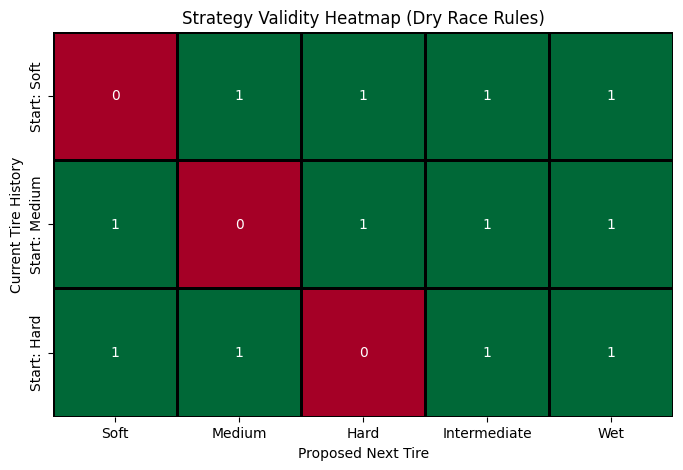

In [17]:
print("--- Pengujian Modul 3: Knowledge-Based Validator ---")
print(f"Skenario A (Soft -> Soft, Dry): {validate_strategy_fol(['Soft'], 'Soft', 'Dry')[1]}")
print(f"Skenario B (Soft -> Medium, Dry): {validate_strategy_fol(['Soft'], 'Medium', 'Dry')[1]}")
print(f"Skenario C (Wet -> Wet, Wet): {validate_strategy_fol(['Wet'], 'Wet', 'Wet')[1]}")

visualize_strategy_validity()

# --- MODUL 4: MESIN KEPUTUSAN STRATEGIS (RACE SIMULATOR) ---

"""
Modul ini mengintegrasikan Modul 1 (Fuzzy), Modul 2 (Probabilistik), dan Modul 3 (Logika) 
untuk mensimulasikan strategi balapan menggunakan data nyata dari FastF1.

**Fitur Utama:**
1. **Data Real-Time:** Mengambil telemetri balapan asli (contoh: Spanish GP 2023).
2. **Decision Engine:** Menentukan 'BOX' atau 'STAY OUT' setiap lap.
3. **Race Replay Dashboard:** Visualisasi keputusan AI vs Strategi Asli.
"""

###  SETUP & LOAD DATA (FASTF1)

In [18]:
import logging
import fastf1
# Suppress FastF1 logs
logging.getLogger('fastf1').setLevel(logging.ERROR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Cache (Opsional, buat folder cache jika belum ada)
if not os.path.exists('fastf1_cache'):
    os.makedirs('fastf1_cache')
fastf1.Cache.enable_cache('fastf1_cache')

print("Loading Race Data (Spanish GP 2023)... This may take a minute.")
# Load Session: Tahun 2023, Grand Prix Spanyol, Sesi Race ('R')
session = fastf1.get_session(2023, 'Spain', 'R')
session.load()

# Ambil data driver tertentu, misal: Max Verstappen (VER)
driver = 'VER'
laps = session.laps.pick_driver(driver)
print(f"Data loaded for driver: {driver}")

Loading Race Data (Spanish GP 2023)... This may take a minute.


Data loaded for driver: VER


c:\Users\WINDOWS\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


### DECISION ENGINE CLAS

In [19]:
class DecisionEngine:
    def __init__(self, driver_laps):
        self.laps = driver_laps.reset_index(drop=True)
        self.history_tires = []
        self.current_tire = None
        self.recommendations = []
        self.urgency_history = []
        
    def run_simulation(self):
        print("\n--- Starting Race Strategy Simulation ---")
        
        for i, row in self.laps.iterrows():
            lap_number = int(row['LapNumber'])
            tire_life = row['TyreLife']
            compound = row['Compound']
            track_status = str(row['TrackStatus']) if 'TrackStatus' in row else '1'
            # Check for SC (4) or VSC (6)
            is_sc_active = '4' in track_status or '6' in track_status
            
            # Update tire history jika ganti ban
            if self.current_tire != compound:
                if self.current_tire is not None:
                    self.history_tires.append(self.current_tire)
                self.current_tire = compound
            
            # --- 1. MODUL 1: FUZZY URGENCY ---
            # Mapping compound string ke nilai fuzzy (Soft=7, Med=5, Hard=3)
            comp_val = 7 if compound == 'SOFT' else (5 if compound == 'MEDIUM' else 3)
            # Asumsi cuaca cerah (10%) untuk Spanish GP 2023
            urgency_score = hitung_urgensi(tire_life, comp_val, 10)
            
            # Boost Urgency if SC is active (Cheap Pit Stop)
            if is_sc_active:
                urgency_score = 10.0 # Max urgency to prioritize pit under SC
            self.urgency_history.append(urgency_score)
            
            # --- 2. MODUL 2: SC RISK (PROBABILISTIK) ---
            # Simulasi: Ambil probabilitas SC untuk Permanent Track, Dry, Low History
            # (Kita hardcode hasil inferensi Modul 2 untuk efisiensi di loop)
            sc_prob = 0.1 # Low risk di Spain biasanya
            
            # --- 3. MODUL 3: REGULATION CHECK ---
            # Cek apakah strategi valid jika kita pit sekarang ke Medium
            is_valid, msg = validate_strategy_fol(self.history_tires, 'Medium', 'Dry')
            
            # --- 4. KEPUTUSAN FINAL ---
            decision = "STAY OUT"
            
            # Logika Keputusan Sederhana
            # Logika Keputusan (Calibrated)
            if urgency_score > 7.5:
                decision = "BOX BOX (High Urgency)"
            elif urgency_score >= 4.5:
                decision = "BOX BOX (Strategic)"
            elif is_sc_active:
                decision = "BOX BOX (Safety Car)"
            elif sc_prob > 0.6:
                decision = "BOX BOX (SC Opportunity)"
                
            # Simpan rekomendasi
            self.recommendations.append({
                'Lap': lap_number,
                'Urgency': urgency_score,
                'Decision': decision,
                'ActualPit': not pd.isna(row['PitInTime'])
            })
            
            # Print jika ada pit stop (Asli atau Rekomendasi)
            # Print HANYA jika ada Pit Stop Asli atau Urgensi SANGAT TINGGI (untuk mengurangi spam)
            # Atau jika user ingin melihat perbandingan saat momen krusial
            actual_pit = not pd.isna(row['PitInTime'])
            if actual_pit or (urgency_score > 6.0 and "BOX" in decision):
                print(f"Lap {lap_number} | Tire: {compound} ({tire_life:.0f} laps) | Urgency: {urgency_score:.2f} | AI: {decision} | Actual: {'PIT' if not pd.isna(row['PitInTime']) else '-'}")

        print("--- Simulation Finished ---")
        return pd.DataFrame(self.recommendations)

# Jalankan Simulasi
engine = DecisionEngine(laps)
results_df = engine.run_simulation()


--- Starting Race Strategy Simulation ---
Lap 24 | Tire: MEDIUM (24 laps) | Urgency: 6.34 | AI: BOX BOX (Strategic) | Actual: -
Lap 25 | Tire: MEDIUM (25 laps) | Urgency: 7.00 | AI: BOX BOX (Strategic) | Actual: -
Lap 26 | Tire: MEDIUM (26 laps) | Urgency: 7.00 | AI: BOX BOX (Strategic) | Actual: PIT
Lap 50 | Tire: HARD (24 laps) | Urgency: 6.34 | AI: BOX BOX (Strategic) | Actual: -


Lap 51 | Tire: HARD (25 laps) | Urgency: 7.00 | AI: BOX BOX (Strategic) | Actual: -


Lap 52 | Tire: HARD (26 laps) | Urgency: 7.00 | AI: BOX BOX (Strategic) | Actual: PIT
--- Simulation Finished ---


### VISUALISASI: RACE REPLAY DASHBOARD

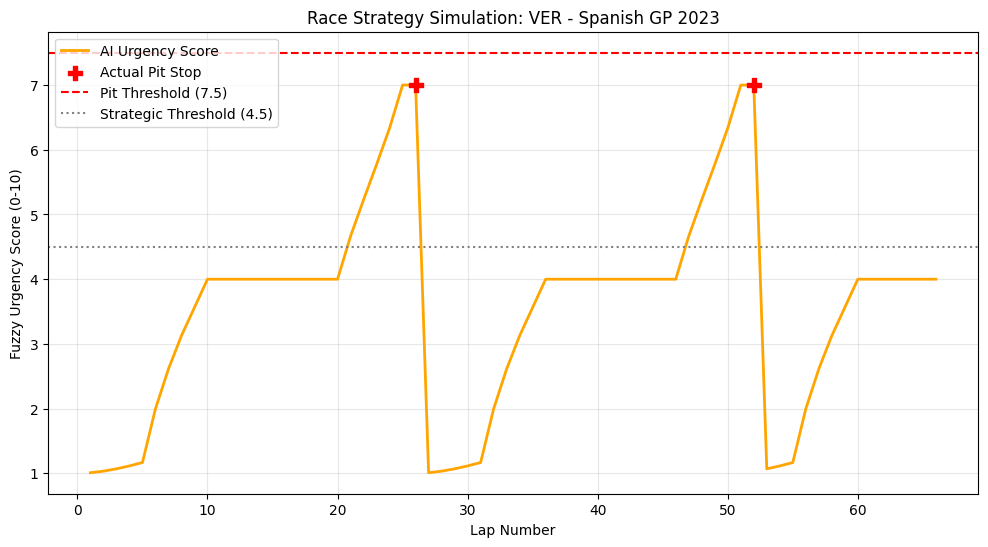

In [20]:
plt.figure(figsize=(12, 6))

# Plot 1: Urgency Tracker
sns.lineplot(data=results_df, x='Lap', y='Urgency', label='AI Urgency Score', color='orange', linewidth=2)

# Plot 2: Pit Stops (Actual vs AI)
# Actual Pits
actual_pits = results_df[results_df['ActualPit'] == True]
plt.scatter(actual_pits['Lap'], actual_pits['Urgency'], color='red', s=100, label='Actual Pit Stop', marker='P', zorder=5)

# AI Recommendations (Threshold > 7.5)
ai_pits = results_df[results_df['Urgency'] > 7.5]
# Filter supaya tidak numpuk (ambil lap pertama saat urgency tembus)
# (Sederhana: scatter semua point urgency tinggi)
# plt.scatter(ai_pits['Lap'], ai_pits['Urgency'], color='blue', s=50, label='AI Recommendation', marker='X')

plt.axhline(y=7.5, color='red', linestyle='--', label='Pit Threshold (7.5)')
plt.axhline(y=4.5, color='grey', linestyle=':', label='Strategic Threshold (4.5)')
plt.title(f"Race Strategy Simulation: {driver} - Spanish GP 2023")
plt.xlabel("Lap Number")
plt.ylabel("Fuzzy Urgency Score (0-10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Modul 5: Real-time Strategy Interface (Manual Input)

Modul ini memungkinkan pengguna untuk memasukkan kondisi balapan saat ini secara manual dan mendapatkan rekomendasi strategi instan.


In [21]:

# --- REAL-TIME ADVISOR CLASS ---

class RealTimeAdvisor:
    def __init__(self):
        self.history_tires = []
        
    def set_history(self, tires_list):
        self.history_tires = tires_list
        
    def get_recommendation(self, current_tire_age, current_compound, 
                          weather_cloud_cover, track_type, sc_history_level, is_safety_car=False):
        
        print(f"\n--- ANALISIS STRATEGI REAL-TIME ---")
        print(f"Kondisi: Ban {current_compound} ({current_tire_age} laps), Cuaca {weather_cloud_cover}%, Trek {track_type}, SC Active: {is_safety_car}")
        
        # 1. MODUL 1: FUZZY URGENCY
        # Mapping compound string ke nilai fuzzy
        comp_map = {'SOFT': 7, 'MEDIUM': 5, 'HARD': 3, 'INTER': 9, 'WET': 10}
        comp_val = comp_map.get(current_compound.upper(), 5)
        
        urgency_score = hitung_urgensi(current_tire_age, comp_val, weather_cloud_cover)
        print(f"1. Urgensi Pit Stop (Fuzzy): {urgency_score:.2f} / 10")
        
        if is_safety_car:
            urgency_score = 10.0
            print(f"   -> SC ACTIVE! Urgency boosted to {urgency_score:.2f} (Cheap Pit Stop)")
        
        # 2. MODUL 2: SC RISK (BAYESIAN INFERENCE)
        # Mapping input ke evidence Bayesian Network
        # Trek: 0=Permanent, 1=Street
        trek_val = 1 if track_type.lower() == 'street' else 0
        # Cuaca: 0=Dry, 1=Wet (Threshold > 50% cloud/rain chance considered Wet for risk)
        cuaca_val = 1 if weather_cloud_cover > 50 else 0
        # Histori: 0=Low, 1=Medium, 2=High
        hist_map = {'low': 0, 'medium': 1, 'high': 2}
        hist_val = hist_map.get(sc_history_level.lower(), 1)
        
        # Inference
        infer = VariableElimination(model)
        q = infer.query(variables=['Probabilitas_SC'], 
                        evidence={'Trek': trek_val, 'Cuaca': cuaca_val, 'Histori_SC': hist_val})
        sc_prob = q.values[1] # Probabilitas SC=1 (Yes)
        print(f"2. Risiko Safety Car (Bayesian): {sc_prob:.2%}")
        
        # 3. MODUL 3: REGULATION CHECK
        weather_cond = "Wet" if weather_cloud_cover > 60 else "Dry"
        # Cek validitas jika pit sekarang ke Medium (sebagai default option)
        # Asumsi kita ganti ke ban yang berbeda untuk memenuhi regulasi jika kering
        next_tire = "MEDIUM" if current_compound.upper() != "MEDIUM" else "HARD"
        is_valid, msg = validate_strategy_fol(self.history_tires, next_tire, weather_cond)
        print(f"3. Validasi Regulasi (FOL): {msg}")
        
        # 4. KEPUTUSAN FINAL
        decision = "STAY OUT"
        reason = "Kondisi ban masih optimal."
        
        # Thresholds (Calibrated)
        if urgency_score > 7.5:
            decision = "BOX BOX"
            reason = "Urgensi ban SANGAT TINGGI (Safety/Performance Critical)."
        elif urgency_score >= 4.5:
            decision = "BOX BOX (Strategic)"
            reason = "Jendela pit stop terbuka (Undercut/Overcut opportunity)."
        elif is_safety_car:
            decision = "BOX BOX (Safety Car)"
            reason = "Safety Car sedang berlangsung, waktu pit stop lebih singkat."
        elif sc_prob > 0.6:
            decision = "BOX BOX (SC Gamble)"
            reason = "Peluang Safety Car tinggi, pit stop murah."
            
        print(f"\n>>> REKOMENDASI AI: {decision} <<<")
        print(f"Alasan: {reason}")
        
        return {
            'Urgency': urgency_score,
            'SC_Prob': sc_prob,
            'Decision': decision
        }

# Inisialisasi Advisor
advisor = RealTimeAdvisor()
print("Real-time Advisor Ready.")


Real-time Advisor Ready.


Circuit coordinates loaded successfully.
Selected Circuit: Monaco (Lat: 43.7347, Lon: 7.4205)
   Fetching real-time weather from Open-Meteo...


   [API] Dry Conditions. Clouds: 79% -> Weather Score: 79

--- ANALISIS STRATEGI REAL-TIME ---
Kondisi: Ban MEDIUM (28 laps), Cuaca 79%, Trek Permanent, SC Active: False
1. Urgensi Pit Stop (Fuzzy): 7.55 / 10
2. Risiko Safety Car (Bayesian): 40.00%
3. Validasi Regulasi (FOL): Valid: Wet Race declared (Mandatory change suspended).

>>> REKOMENDASI AI: BOX BOX <<<
Alasan: Urgensi ban SANGAT TINGGI (Safety/Performance Critical).


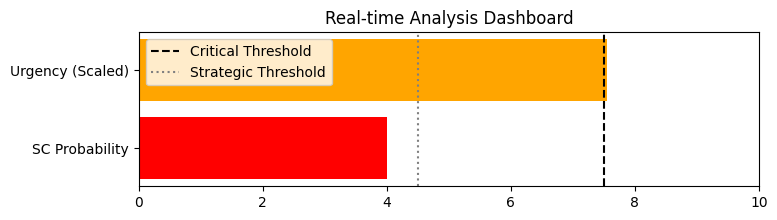

In [22]:
import requests

def get_real_weather(lat, lon):
    try:
        # Menggunakan parameter minutely_15 untuk prediksi jangka pendek (Strategic)
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&minutely_15=rain,weather_code,precipitation&current=cloud_cover&forecast_days=1"
        response = requests.get(url)
        data = response.json()
        
        # 1. Cek Kondisi Sekarang (Cloud Cover)
        current = data.get('current', {})
        cloud_cover = current.get('cloud_cover', 0)
        
        # 2. Cek Prediksi 15 Menit ke Depan (Minutely 15)
        minutely = data.get('minutely_15', {})
        precip = minutely.get('precipitation', [0, 0])
        
        # Ambil data sekarang (index 0) dan 15 menit lagi (index 1)
        rain_now = precip[0] if len(precip) > 0 else 0
        rain_next_15 = precip[1] if len(precip) > 1 else 0
        
        # Logic Mapping ke Skala 0-100 (Fuzzy Input)
        weather_score = cloud_cover # Default: Dry/Cloudy
        
        if rain_now > 0.1:
            weather_score = 95 # Wet (Hujan Sekarang)
            print(f"   [API] RAIN DETECTED! Precip: {rain_now}mm -> Weather Score: {weather_score} (WET)")
        elif rain_next_15 > 0.1:
            weather_score = 85 # Incoming Rain (Hujan sebentar lagi)
            print(f"   [API] WARNING: INCOMING RAIN in 15 mins! Precip: {rain_next_15}mm -> Weather Score: {weather_score} (PREPARE INTERS)")
        else:
            print(f"   [API] Dry Conditions. Clouds: {cloud_cover}% -> Weather Score: {weather_score}")
            
        return weather_score
    except Exception as e:
        print(f"   [API Error] Could not fetch weather: {e}. Using default 10%.")
        return 10
# --- LOAD CIRCUIT COORDINATES ---
try:
    circuits_df = pd.read_csv('circuit coordinate.csv')
    # Create a dictionary for easy lookup: Venue -> (Lat, Lon)
    circuit_coords = dict(zip(circuits_df['Venue'], zip(circuits_df['Latitude'], circuits_df['Longitude'])))
    print("Circuit coordinates loaded successfully.")
except FileNotFoundError:
    print("Warning: 'circuit coordinate.csv' not found. Using default coordinates.")
    circuit_coords = {'Monaco': (43.7347, 7.4205)}

# --- INTERFACE INPUT PENGGUNA ---
# Ubah nilai di bawah ini sesuai kondisi balapan saat ini:

# --- INTERFACE INPUT PENGGUNA ---
# Pilih Sirkuit dari: 'Monaco', 'Silverstone', 'Spa-Francorchamps',
INPUT_CIRCUIT = 'Monaco'   # Nama Sirkuit (Sesuai CSV)

INPUT_TIRE_AGE = 28        # Umur ban saat ini (lap)
INPUT_COMPOUND = 'MEDIUM'  # Tipe ban: SOFT, MEDIUM, HARD, INTER, WET
INPUT_WEATHER = 10         # Default (akan ditimpa jika API sukses)
INPUT_TRACK = 'Permanent'  # Tipe trek: Street atau Permanent

# Get Coordinates
if INPUT_CIRCUIT in circuit_coords:
    lat, lon = circuit_coords[INPUT_CIRCUIT]
    print(f"Selected Circuit: {INPUT_CIRCUIT} (Lat: {lat}, Lon: {lon})")
    # Di sini kita bisa memanggil API Cuaca real-time menggunakan lat/lon
    print(f"   Fetching real-time weather from Open-Meteo...")
    INPUT_WEATHER = get_real_weather(lat, lon)
else:
    print(f"Circuit '{INPUT_CIRCUIT}' not found. Using manual weather input.")
INPUT_SC_HIST = 'Low'      # Histori SC: Low, Medium, High
INPUT_IS_SC = False        # Apakah sedang ada Safety Car? (True/False)
INPUT_HISTORY = ['SOFT']   # Ban yang sudah dipakai sebelumnya

# Set History
advisor.set_history(INPUT_HISTORY)

# Dapatkan Rekomendasi
result = advisor.get_recommendation(
    current_tire_age=INPUT_TIRE_AGE,
    current_compound=INPUT_COMPOUND,
    weather_cloud_cover=INPUT_WEATHER,
    track_type=INPUT_TRACK,
    sc_history_level=INPUT_SC_HIST,
    is_safety_car=INPUT_IS_SC
)

# Visualisasi Simple
plt.figure(figsize=(8, 2))
plt.barh(['SC Probability', 'Urgency (Scaled)'], [result['SC_Prob']*10, result['Urgency']], color=['red', 'orange'])
plt.xlim(0, 10)
plt.axvline(x=7.5, color='black', linestyle='--', label='Critical Threshold')
plt.axvline(x=4.5, color='grey', linestyle=':', label='Strategic Threshold')
plt.title("Real-time Analysis Dashboard")
plt.legend()
plt.show()